# Data setup

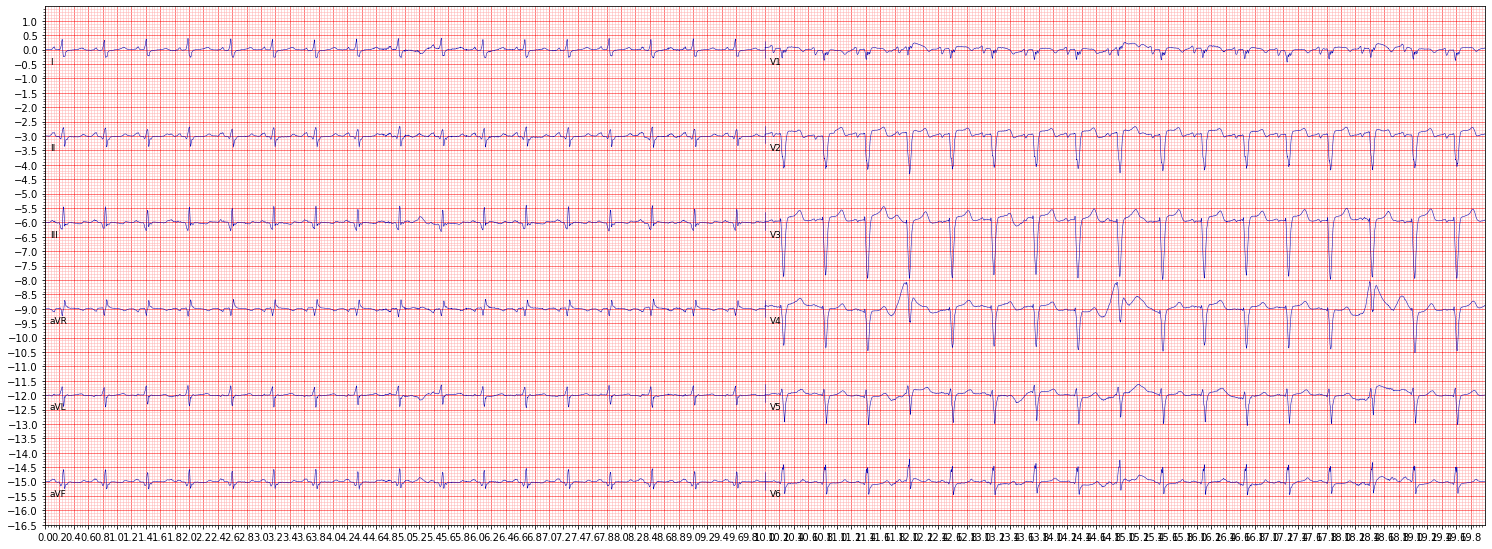

In [1]:
import physionet_challenge_utility_script as pc

import ecg_plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
%load_ext autoreload
%autoreload
%reload_ext autoreload

def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
plot_ecg("SM22_MLData/China12Lead/Q0001.mat")


In [2]:
DATADIR = "./SM22_MLData"

In [3]:
gender, age, labels, ecg_filenames = pc.import_key_data(DATADIR)
ecg_filenames = np.asarray(ecg_filenames)

<AxesSubplot:>

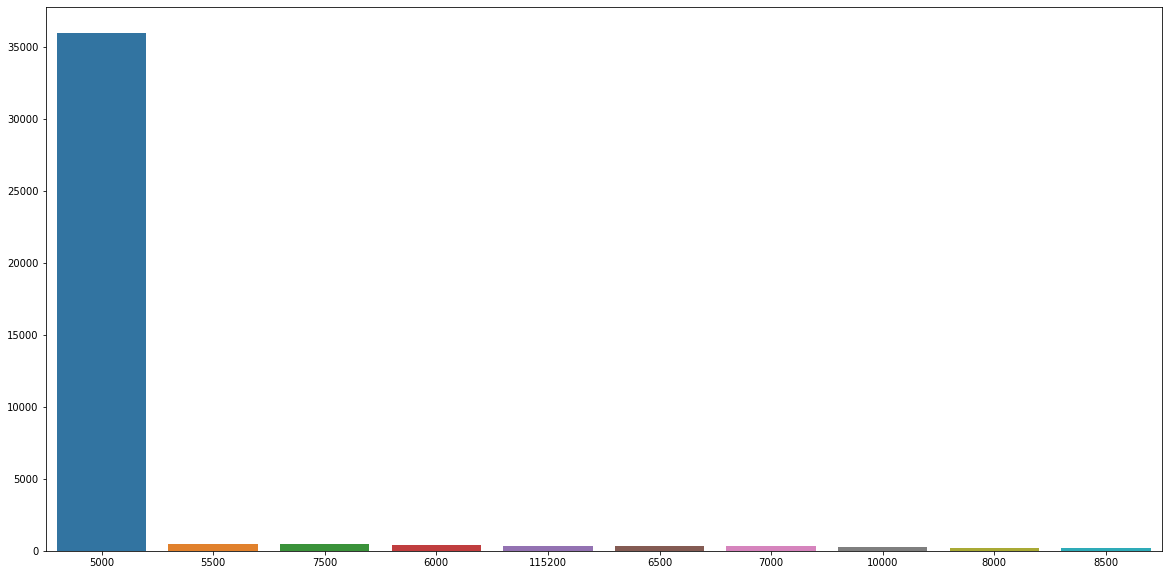

In [4]:
import os
signal_length=[]
for subdir, dirs, files in sorted(os.walk(DATADIR)):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".mat"):
            data, header_data = pc.load_challenge_data(filepath)
            splitted = header_data[0].split()
            signal_length.append(splitted[3])
signal_length_df = pd.DataFrame(signal_length)
signal_count = signal_length_df[0].value_counts()
plt.figure(figsize=(20,10))
#plt.title(title,fontsize =36)
sns.barplot(x=signal_count[:10,].index, y=signal_count[:10,].values)

In [28]:
labels

['164867002,426627000',
 '164867002,427084000',
 '164930006',
 '195080001,164867002,164889003,164934002',
 '164861001,428750005',
 '164930006',
 '428750005',
 '164930006,426627000',
 '251120003,164867002,428750005',
 '164867002',
 '164867002',
 '164867002',
 '164865005,164931005',
 '17338001,427084000,428750005,428750005',
 '164867002,427084000',
 '164930006',
 '164867002,164909002,428750005',
 '164865005',
 '713426002,164861001',
 '164861001',
 '164861001,428750005',
 '164889003,428750005',
 '164930006,427084000',
 '164867002',
 '164867002,428750005',
 '164861001,428750005,426627000',
 '164867002,164934002',
 '428750005',
 '164867002',
 '164867002',
 '164930006',
 '164867002,164865005,426627000',
 '164867002,164930006,427084000',
 '63593006,195080001,164889003',
 '428750005',
 '164930006',
 '164867002',
 '164865005',
 '164867002,428750005',
 '164865005,428750005',
 '251120003,428750005,427084000',
 '713426002,713427006,164930006',
 '164865005',
 '428750005',
 '428750005,59931005',
 '4

In [6]:
age, gender = pc.import_gender_and_age(age, gender)

gender data shape: 43101
age data shape: 43101


In [22]:
SNOMED_scored=pd.read_csv(f"{DATADIR}/SNOMEDMappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv(f"{DATADIR}/SNOMEDMappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [9]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


In [10]:
snomed_abbr = []
for j in range(len(snomed_classes)):
    for i in range(len(SNOMED_scored.iloc[:,1])):
        if (str(SNOMED_scored.iloc[:,1][i]) == snomed_classes[j]):
            snomed_abbr.append(SNOMED_scored.iloc[:,2][i])
            
snomed_abbr = np.asarray(snomed_abbr)
snomed_abbr

array(['PR', 'LQT', 'AF', 'AFL', 'LBBB', 'QAb', 'TAb', 'LPR', 'VPB',
       'LQRSV', 'IAVB', 'PAC', 'LAD', 'SB', 'Brady', 'SNR', 'STach',
       'PVC', 'SA', 'LAnFB', 'RAD', 'RBBB', 'TInv', 'SVPB', 'NSIVCB',
       'IRBBB', 'CRBBB'], dtype='<U6')

In [11]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 1414


In [12]:
folds = pc.split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


/Users/ksv/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


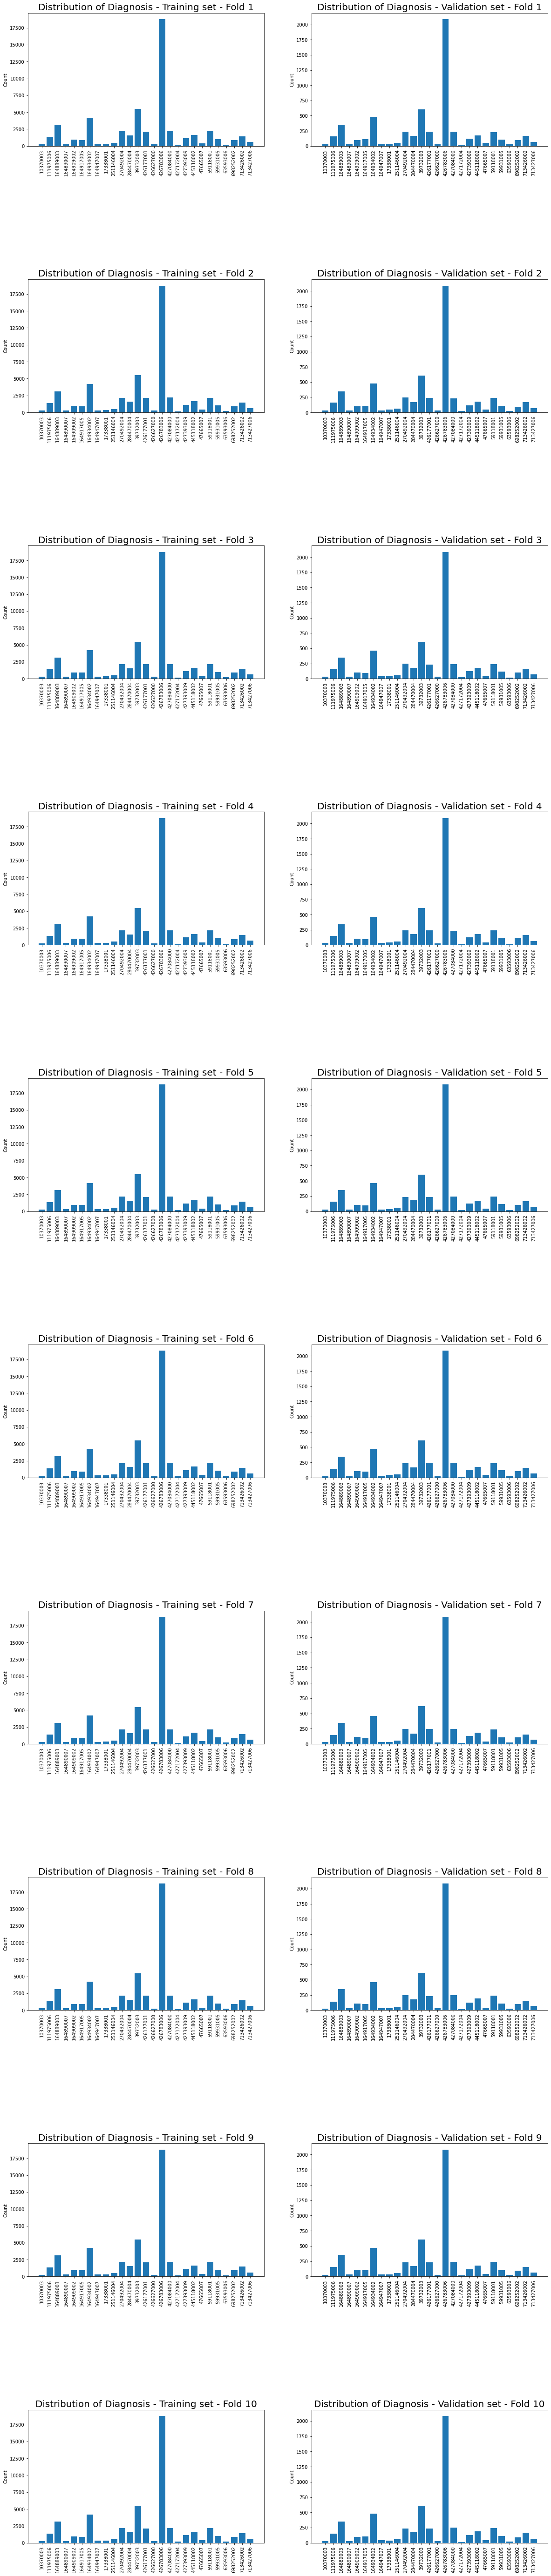

In [13]:
pc.plot_all_folds(folds,y,snomed_classes)

In [14]:
order_array = folds[0][0]
order_array

array([    0,     1,     2, ..., 43098, 43099, 43100])

In [15]:
folds

[(array([    0,     1,     2, ..., 43098, 43099, 43100]),
  array([   25,    45,    51, ..., 43061, 43071, 43087])),
 (array([    0,     2,     4, ..., 43098, 43099, 43100]),
  array([    1,     3,    13, ..., 43074, 43075, 43079])),
 (array([    0,     1,     2, ..., 43098, 43099, 43100]),
  array([    7,    26,    30, ..., 43064, 43076, 43086])),
 (array([    0,     1,     2, ..., 43097, 43099, 43100]),
  array([   36,    56,    67, ..., 43090, 43093, 43098])),
 (array([    0,     1,     2, ..., 43097, 43098, 43099]),
  array([    6,    10,    12, ..., 43077, 43095, 43100])),
 (array([    0,     1,     2, ..., 43098, 43099, 43100]),
  array([    5,     9,    17, ..., 43084, 43085, 43092])),
 (array([    0,     1,     2, ..., 43095, 43098, 43100]),
  array([   16,    22,    34, ..., 43096, 43097, 43099])),
 (array([    0,     1,     2, ..., 43098, 43099, 43100]),
  array([   40,    46,    54, ..., 43073, 43083, 43094])),
 (array([    0,     1,     2, ..., 43098, 43099, 43100]),
  arra

In [16]:
def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels
        
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

In [17]:
new_weights = pc.calculating_class_weights(y)

In [18]:
new_weights

array([[  0.50349283,  72.07525084],
       [  0.51819034,  14.24355585],
       [  0.54384747,   6.20158273],
       [  0.50366934,  68.63216561],
       [  0.51237518,  20.70172911],
       [  0.51203431,  21.2739388 ],
       [  0.56080202,   4.61170554],
       [  0.50397559,  63.38382353],
       [  0.5042704 ,  59.04246575],
       [  0.50653426,  38.75989209],
       [  0.52940526,   9.0018797 ],
       [  0.52089577,  12.46414112],
       [  0.58220991,   3.54099573],
       [  0.52895047,   9.13543875],
       [  0.50336346,  74.828125  ],
       [  0.96834419,   1.03379545],
       [  0.52950932,   8.97189842],
       [  0.50219048, 114.63031915],
       [  0.51481092,  17.37943548],
       [  0.52186705,  11.93272425],
       [  0.50500305,  50.46955504],
       [  0.52950932,   8.97189842],
       [  0.51324156,  19.37994604],
       [  0.50250665, 100.23488372],
       [  0.51183973,  21.61534604],
       [  0.51941432,  13.37709497],
       [  0.50805083,  31.55270864]])

In [19]:
keys = np.arange(0,27,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

{0: 72.0752508361204,
 1: 14.243555849306015,
 2: 6.201582733812949,
 3: 68.63216560509554,
 4: 20.701729106628243,
 5: 21.273938795656466,
 6: 4.611705542478066,
 7: 63.383823529411764,
 8: 59.04246575342466,
 9: 38.759892086330936,
 10: 9.00187969924812,
 11: 12.464141122035858,
 12: 3.5409957279000985,
 13: 9.13543874523103,
 14: 74.828125,
 15: 1.0337954523649622,
 16: 8.971898417985013,
 17: 114.63031914893617,
 18: 17.379435483870967,
 19: 11.932724252491694,
 20: 50.469555035128806,
 21: 8.971898417985013,
 22: 19.379946043165468,
 23: 100.23488372093023,
 24: 21.615346038114343,
 25: 13.37709497206704,
 26: 31.552708638360176}

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [21]:
from scipy import optimize
def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

# Model

In [30]:
model = pc.FCN()

Metal device set to: Apple M1


2022-03-09 19:16:45.737661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 19:16:45.738025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
batchsize = 30

model.fit(x=shuffle_batch_generator(batch_size=batchsize, 
                                    gen_x=generate_X_shuffle(ecg_filenames), 
                                    gen_y=generate_y_shuffle(y)), epochs=30, 
          steps_per_epoch=(len(order_array)/batchsize), 
          validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), validation_freq=1, class_weight=weight_dictionary, callbacks=[reduce_lr,early_stop])

In [32]:
model.load_weights("/Users/ksv/Downloads/fcn_model.h5")

In [51]:
y_pred = model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])


In [52]:
pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0]

array([[[ -211,  -218,  -220, ...,  -216,  -223,  -217],
        [ -209,  -204,  -200, ...,  -204,  -192,  -182],
        [ -175,  -178,  -184, ...,  -168,  -179,  -187],
        ...,
        [  348,   285,   229, ...,    11,    -2,   -12],
        [  -20,   -26,   -31, ...,   -52,   -55,   -57],
        [  -58,   -59,   -58, ...,   -58,   -60,   -62]],

       [[   31,    45,    38, ...,    20,    15,    -8],
        [  -17,   -23,   -26, ...,   -30,   -26,   -33],
        [  -36,   -27,   -17, ...,   -30,   -24,   -27],
        ...,
        [  -14,    -4,     9, ...,    21,    24,    27],
        [   22,    22,    19, ...,    15,    12,     9],
        [    2,    -1,     2, ...,   -12,   -14,   -17]],

       [[   -4,    -5,    -8, ...,   -29,   -16,   -17],
        [  -23,   -13,   -18, ...,   -18,   -23,   -30],
        [  -26,   -19,   -27, ...,   -32,   -37,   -32],
        ...,
        [  -61,   -58,   -50, ...,   -53,   -53,   -51],
        [  -58,   -68,   -69, ...,   -68,   -

In [53]:
y_pred

array([[8.25357565e-04, 8.53345916e-03, 1.15926820e-03, ...,
        1.00784062e-03, 1.43442850e-03, 3.15516139e-04],
       [4.76773595e-04, 3.58900167e-02, 4.27840790e-03, ...,
        3.13576846e-03, 1.55409682e-03, 1.65556805e-04],
       [3.53464478e-04, 2.19505541e-02, 5.27744356e-04, ...,
        3.71199887e-04, 6.20840176e-04, 4.72771035e-06],
       ...,
       [8.39866581e-04, 2.41705839e-05, 1.15122534e-01, ...,
        2.93737918e-01, 2.45037735e-01, 2.40788534e-01],
       [4.16352041e-03, 6.91043679e-04, 2.69337557e-02, ...,
        3.92497107e-02, 2.70460024e-02, 1.15358466e-02],
       [4.05211467e-04, 5.78168023e-04, 1.10408831e-02, ...,
        1.96846924e-03, 5.96524402e-03, 4.02243622e-03]], dtype=float32)

In [35]:
init_thresholds = np.arange(0,1,0.05)

In [36]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1])

0.15079791501474246
0.31299989604269657
0.3382170398706478
0.31010275037598495
0.25670585541524876
0.19728966082038746
0.13368454690954917
0.07722734233062242
0.0036242900858597295
-0.05380789957250145
-0.12029894973904913
-0.18704371652778842
-0.25584260898538913
-0.32242703432772873
-0.39473054933436186
-0.47340611593415977
-0.5628750813332494
-0.6512351990381826
-0.7402393164265819
-0.8027197676016324


In [54]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))#

Optimization terminated successfully.
         Current function value: -0.355319
         Iterations: 336
         Function evaluations: 598


In [55]:
print(pc.compute_challenge_metric_for_opt(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],(y_pred>new_best_thr)*1))#

0.35531911496508184


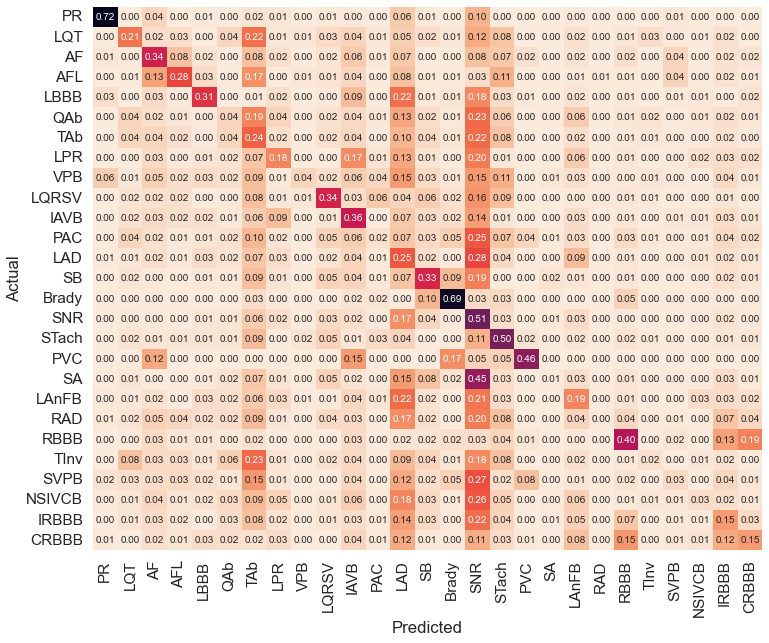

In [56]:
pc.plot_normalized_conf_matrix(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes,snomed_abbr)
plt.savefig("confusion_matrix_fcn.png", dpi = 100)

In [57]:
from sklearn.metrics import confusion_matrix

In [63]:
confusion_matrix(pc.generate_validation_data(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],(y_pred>new_best_thr)*1))

TypeError: generate_validation_data() missing 1 required positional argument: 'test_order_array'